## Weather project for "Python: Data Analysis" LinkedIn cource

Exploring history of weather in Kyiv, using data from Kyiv station "UPM00033345 KIEV" (50.4000   30.5331)

In [86]:
import numpy as np
import matplotlib.pyplot as pp
import seaborn

In [87]:
%matplotlib inline

### Parsing of datafile

In [88]:
def parsefile(filename):
    return np.genfromtxt(filename,
                         delimiter = dly_delimiter,
                         usecols = dly_usecols,
                         dtype = dly_dtype,
                         names = dly_names)

In [89]:
dly_delimiter = [11,4,2,4] + [5,1,1,1] * 31
dly_usecols = [1,2,3] + [4*i for i in range(1,32)]
dly_dtype = [np.int32,np.int32,(np.str_,4)] + [np.int32] * 31
dly_names = ['year','month','obs'] + [str(day) for day in range(1,31+1)]

In [90]:
kyiv = parsefile('UPM00033345.dly')

In [91]:
kyiv

array([(1881, 1, 'TMAX',    22,    10,   -21,     1,     6,   -15,   -16,   -11,   -72,   -82,   -40,   -62,  -109,   -66,  -135,  -125,  -115,   -84,  -140,   -60,   -71,  -124,  -109,  -111,  -107,   -86,  -155,  -151,   -65,   -38,   -45),
       (1881, 1, 'TMIN',    -6,   -55,   -72,   -51,   -69,   -51,   -88,   -69,  -144,  -152,  -100,  -116,  -164,  -127,  -197,  -200,  -150,  -154,  -181,  -145,  -136,  -156,  -159,  -177,  -189,  -171,  -202,  -212,  -160,   -71,   -65),
       (1881, 1, 'PRCP',     0,     0,     0,     0,     0,     0,     0,     0,     6,     0,     0,     0,    46,    30,     0,     0,    12,     0,     5,    36,     1,     0,     0,     0,     0,     0,     0,     0,     4,     0,     0),
       ...,
       (2020, 6, 'TMIN', -9999, -9999,    55, -9999, -9999,   143, -9999, -9999,   193, -9999,   204, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999, -9999),
       (2020, 6,

### Extracting temperature observation data

In [92]:
def unroll(record):
    startdate = np.datetime64('{}-{:02}'.format(record['year'],record['month']))
    dates = np.arange(startdate,startdate + np.timedelta64(1,'M'),np.timedelta64(1,'D'))
    
    rows = [(date,record[str(i+1)]/10) for i,date in enumerate(dates)]
    
    return np.array(rows,dtype=[('date','M8[D]'),('value','d')])

In [93]:
unroll(kyiv[0])

array([('1881-01-01',   2.2), ('1881-01-02',   1. ),
       ('1881-01-03',  -2.1), ('1881-01-04',   0.1),
       ('1881-01-05',   0.6), ('1881-01-06',  -1.5),
       ('1881-01-07',  -1.6), ('1881-01-08',  -1.1),
       ('1881-01-09',  -7.2), ('1881-01-10',  -8.2),
       ('1881-01-11',  -4. ), ('1881-01-12',  -6.2),
       ('1881-01-13', -10.9), ('1881-01-14',  -6.6),
       ('1881-01-15', -13.5), ('1881-01-16', -12.5),
       ('1881-01-17', -11.5), ('1881-01-18',  -8.4),
       ('1881-01-19', -14. ), ('1881-01-20',  -6. ),
       ('1881-01-21',  -7.1), ('1881-01-22', -12.4),
       ('1881-01-23', -10.9), ('1881-01-24', -11.1),
       ('1881-01-25', -10.7), ('1881-01-26',  -8.6),
       ('1881-01-27', -15.5), ('1881-01-28', -15.1),
       ('1881-01-29',  -6.5), ('1881-01-30',  -3.8),
       ('1881-01-31',  -4.5)],
      dtype=[('date', '<M8[D]'), ('value', '<f8')])

In [94]:
def getobs(filename,obs):
    data = np.concatenate([unroll(row) for row in parsefile(filename) if row[2] == obs])
    
    data['value'][data['value'] == -999.9] = np.nan
    
    return data

In [95]:
kyiv_tmax = getobs('UPM00033345.dly','TMAX')
kyiv_tmin = getobs('UPM00033345.dly','TMIN')
print(len(kyiv_tmax))
np.savetxt('kyiv_tmax.txt', kyiv_tmax, fmt='%s')
kyiv_tmax

50524


array([('1881-01-01',  2.2), ('1881-01-02',  1. ), ('1881-01-03', -2.1),
       ..., ('2020-06-28',  nan), ('2020-06-29',  nan),
       ('2020-06-30',  nan)], dtype=[('date', '<M8[D]'), ('value', '<f8')])

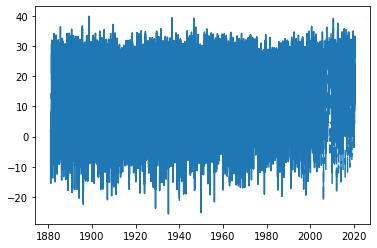

In [96]:
pp.plot(kyiv_tmax['date'],kyiv_tmax['value'])
#pp.plot(kyiv_tmin['date'],kyiv_tmin['value'])
#46000:47524

In [97]:
def plot_smoothed(t,win=10):
    smoothed = np.correlate(t['value'],np.ones(win)/win,'same')
    
    pp.plot(t['date'],smoothed)

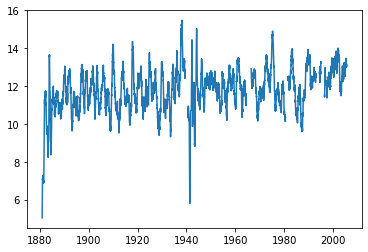

In [98]:
plot_smoothed(kyiv_tmax,365)

### Data processing: filling of NANs

In [99]:
def fillnans(data):
    data1 = data.copy()
    dates_float = data1['date'].astype(np.float64)
    
    nan = np.isnan(data1['value'])
    
    data1['value'][nan] = np.interp(dates_float[nan],dates_float[~nan],data1['value'][~nan])
    return data1

In [100]:
kyiv_tmax_filled = fillnans(kyiv_tmax)
kyiv_tmin_filled = fillnans(kyiv_tmin)
np.savetxt('kyiv_tmax_filled.txt', kyiv_tmax_filled, fmt='%s')

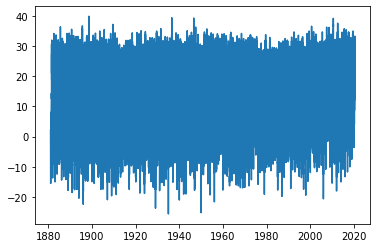

In [101]:
pp.plot(kyiv_tmax_filled['date'],kyiv_tmax_filled['value'])

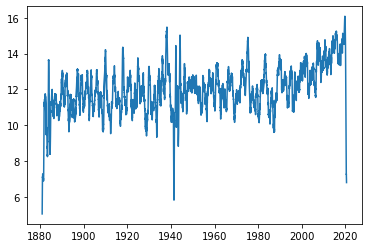

In [102]:
plot_smoothed(kyiv_tmax_filled,365)

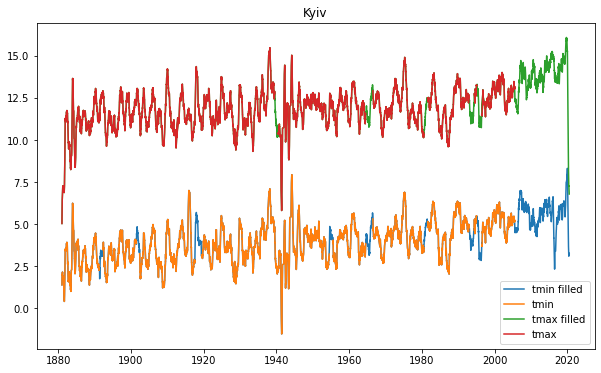

In [103]:
pp.figure(figsize=(10,6))
plot_smoothed(kyiv_tmin_filled,365)
plot_smoothed(kyiv_tmin,365)
plot_smoothed(kyiv_tmax_filled,365)
plot_smoothed(kyiv_tmax,365)
pp.legend(['tmin filled','tmin','tmax filled','tmax',])
pp.title('Kyiv')
pp.show()

### Extracting yearly information

In [104]:
def selectyear(data,year):
    start = np.datetime64('{}'.format(year))
    end = start + np.timedelta64(1,'Y')
    
    return data[(data['date'] >= start) & (data['date'] < end)]['value']

In [142]:
max80 = selectyear(kyiv_tmax_filled, 1980)
min80 = selectyear(kyiv_tmin_filled, 1980)
min80

array([ -2.9,  -3.1,  -4.7,  -2.1,  -1.8,  -4.4,  -4.8, -10.7, -12.1,
       -13.4, -13.9, -12.9, -13.6,  -8.9, -12.8, -10.4, -12.5, -16. ,
       -14. , -10.1, -10.6, -15.3, -15.6, -11.6,  -1.6,  -2.7, -11.5,
       -14. , -17.4, -18.1,  -9.7,   2.8,  -3.3,  -7.1,  -6.4,  -2.1,
         0.3,   0.4,   0.4,  -0.1,  -6.1,  -5.1,  -9.1, -14.7, -15. ,
       -13.3, -13.6, -13.4, -10. ,  -9.4, -10.2,  -7.8,  -3.6,  -4. ,
        -6.6,  -7.1,  -6.3,  -7.1,  -8.6, -11.2, -10.3,  -9.3,  -3.9,
        -6.6,  -9.1,  -9.4,  -7. ,  -3.8,  -6. ,  -2.6,  -4.6,  -9.7,
       -11.1,  -9.3,  -9.7,  -8.8,  -6.3,  -7. , -10.3, -11.2,  -7.9,
        -8.1,  -9.7,  -9.8,  -6.1,  -3.2,  -1.1,  -4.4,   0.3,  -2.1,
         0.6,   0.1,   2.5,   3.4,   2.9,   1.5,   1.9,   1.7,   0. ,
        -0.1,   0.5,   2.7,   0.2,   0.5,   3.2,   1.3,  -0.7,   1.9,
         0.3,   4.5,   4.4,   4.7,   7.7,  10. ,   8.9,   5.3,   6.9,
         8.7,   8.8,   7. ,  10.5,  11.6,  11.5,   3.6,   2.2,   3.5,
         5.4,   7.7,

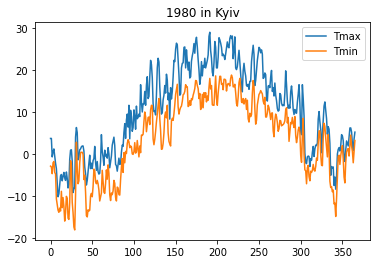

In [106]:
pp.plot(max80)
pp.plot(min80)
pp.title('1980 in Kyiv')
pp.legend(['Tmax','Tmin'])
pp.show()

In [135]:
kyiv_tmin_all = np.vstack([selectyear(kyiv_tmin_filled,year)[:365] for year in range(1950,2014)])
kyiv_tmax_all = np.vstack([selectyear(kyiv_tmax_filled,year)[:365] for year in range(1950,2014)])

In [136]:
kyiv_tmin_recordmin = np.min(kyiv_tmin_all,axis=0)
kyiv_tmin_recordmax = np.max(kyiv_tmin_all,axis=0)

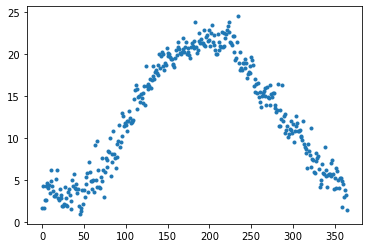

In [137]:
pp.plot(kyiv_tmin_recordmax,'.')

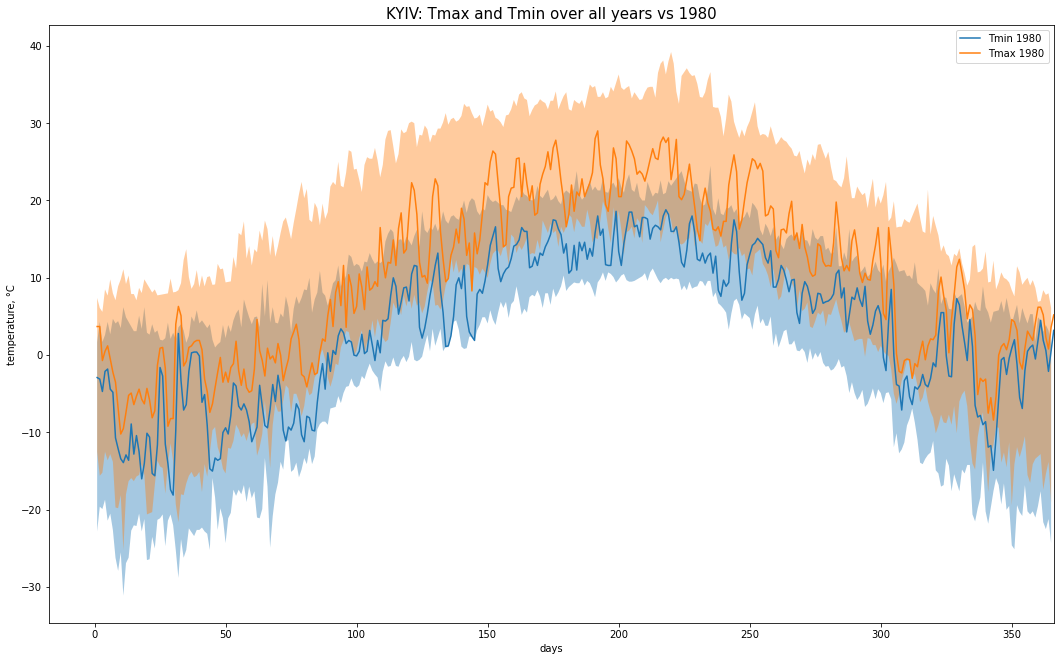

In [149]:
pp.figure(figsize=(18,11))

days = np.arange(1,366)
days1 = np.arange(1,367)
pp.fill_between(days,np.min(kyiv_tmin_all,axis=0),np.max(kyiv_tmin_all,axis=0),alpha=0.4)
pp.plot(days1, selectyear(kyiv_tmin_filled,1980))

pp.fill_between(days,np.min(kyiv_tmax_all,axis=0),np.max(kyiv_tmax_all,axis=0),alpha=0.4)
pp.plot(days1, selectyear(kyiv_tmax_filled,1980))

pp.axis(xmax=366)
pp.xlabel('days')
pp.ylabel('temperature, °C')
pp.title('KYIV: Tmax and Tmin over all years vs 1980', fontsize=15)
pp.legend(['Tmin 1980','Tmax 1980'])
pp.show()